In [2]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
from torchvision import datasets, transforms
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import tqdm
import time

In [3]:
def extract_model_params(model):
    """Extract all parameters of a PyTorch model."""
    return torch.cat([p.view(-1) for p in model.parameters() if p.requires_grad])

In [4]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X, y in loader:
            logits = model(X)
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    return correct / total

In [5]:
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for X, y in loader:
        optimizer.zero_grad()
        logits = model(X)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X.size(0)

    all_params = extract_model_params(model)

    return running_loss / len(loader.dataset), all_params.detach().cpu().numpy()

In [6]:
def sgd_weight_decay_weights_only(model, lr, weight_decay):
    wd, nowd = [], []
    for name, p in model.named_parameters():
        if not p.requires_grad:
            continue
        if p.ndim == 1 or name.endswith("bias"):
            nowd.append(p)
        else:
            wd.append(p)

    return torch.optim.SGD(
        [{"params": wd, "weight_decay": weight_decay},
         {"params": nowd, "weight_decay":0.0}], lr=lr
    )

In [7]:
def build_mlp(input_dim, n_layers, hidden_units, output_dim):
    """Build an MLP with `n_layers` hidden linear+ReLU layers and a linear output.
    
    Returns
    -------
    nn.Module
        The constructed MLP.
    """
    layers = []
    in_dim = input_dim

    for _ in range(n_layers):
        layers.append(nn.Linear(in_dim, hidden_units))
        layers.append(nn.ReLU())
        in_dim = hidden_units

    layers.append(nn.Linear(in_dim, output_dim))
    return nn.Sequential(*layers)

In [8]:
def hyperparam_tuning(train_dataset, val_dataset, seed=541):
    """Systematically search hyperparameters and return the best config and model state.

    Returns
    -------
    dict, state_dict
        Best hyperparameters and the corresponding model state dict.
    """
    torch.manual_seed(seed)
    np.random.seed(seed)

    best_cfg, best_acc = None, 0.0
    count = 0
    n_features = train_dataset[0][0].numel()
    n_classes = int(torch.max(torch.tensor([y for _, y in train_dataset])) +1)

    '''
    grid_layers = [3,4,5]
    grid_hidden = [30,40,50]
    grid_lrs = [0.001,0.005,0.01,0.05,0.1,0.5]
    grid_batches = [16,32,64,128,256]
    grid_epochs = [10,12]
    grid_l2 = [1e-4,5e-4,1e-3]
    '''
    grid_layers = [3,4,5]
    grid_hidden = [30,40,50]
    grid_lrs = [0.01,0.05]
    grid_batches = [32,64]
    grid_epochs = [10]
    grid_l2 = [1e-4,5e-4]

    trials = []
    for L in grid_layers:
        for H in grid_hidden:
            for lr in grid_lrs:
                trials.append({"layers": L, "hidden": H, "lr": lr})

    for t in trials:
        for bs in grid_batches:
            for ep in grid_epochs:
                for l2 in grid_l2:
                    tm0 = time.time()
                    cfg = dict(
                        n_layers = t["layers"], hidden_units = t["hidden"],
                        lr = t["lr"], batch_size = bs, epochs = ep, l2 = l2
                    )
                    
                    train_loader = DataLoader(train_dataset, batch_size=cfg["batch_size"], shuffle=True)
                    val_loader = DataLoader(val_dataset, batch_size=cfg["batch_size"], shuffle=True)

                    model = build_mlp(n_features, cfg["n_layers"], cfg["hidden_units"], n_classes)
                    criterion = nn.CrossEntropyLoss()
                    optimizer = sgd_weight_decay_weights_only(model, cfg["lr"], cfg["l2"])

                    for _ in range(cfg["epochs"]):
                        train_epoch(model, train_loader, criterion, optimizer)

                    val_acc = evaluate(model, val_loader)
                    if val_acc > best_acc:
                        best_acc = val_acc
                        best_cfg = cfg.copy()
                    count += 1
                    print(f"Hyperparameter Epoch {count}: val_acc={val_acc:.4f}, best_acc={best_acc:.4f}, time={time.time()-tm0:.1f}s")

    return best_cfg, best_acc

In [9]:
# Load data (numpy arrays assumed present in workspace)
X_train = np.load("fashion_mnist_train_images.npy").astype(np.float32) / 255.0
y_train = np.load("fashion_mnist_train_labels.npy").astype(np.int64)
X_test = np.load("fashion_mnist_test_images.npy").astype(np.float32) / 255.0
y_test = np.load("fashion_mnist_test_labels.npy").astype(np.int64)

# Flatten if images are HxW
if X_train.ndim == 3:
    X_train = X_train.reshape(X_train.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)

# center data similarly to previous versions
X_train = X_train - 0.5
X_test = X_test - 0.5

# Convert to tensors
X_train_t = torch.from_numpy(X_train)
y_train_t = torch.from_numpy(y_train)
X_test_t = torch.from_numpy(X_test)
y_test_t = torch.from_numpy(y_test)

# Train/val split
full_train = TensorDataset(X_train_t, y_train_t)
val_size = int(0.2 * len(full_train))
train_size = len(full_train) - val_size
train_dataset, val_dataset = random_split(full_train, [train_size, val_size])


# Run hyperparameter tuning
best_cfg, best_acc = hyperparam_tuning(train_dataset, val_dataset)
print(f"Best config: {best_cfg} with val_acc={best_acc:.4f}")

# Retrain best model on full training set (train+val) for more epochs
n_features = X_train.shape[1]
n_classes = int(y_train.max() + 1)

# Instantiate the best model
best_model = build_mlp(n_features, best_cfg["n_layers"], best_cfg["hidden_units"], n_classes)

# create full training loader and test loader
batch_size = best_cfg["batch_size"]
full_train_loader = DataLoader(full_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=batch_size, shuffle=False)
criterion = nn.CrossEntropyLoss()
optimizer = sgd_weight_decay_weights_only(best_model, best_cfg["lr"], best_cfg["l2"])

# retrain best model
epochs_final = 50
parameter_history = []  # To store the history of parameters
for epoch in range(epochs_final):
    t0 = time.time()
    loss, flat_parans = train_epoch(best_model, full_train_loader, criterion, optimizer)
    t1 = time.time()
    parameter_history.append(flat_parans)
    test_acc = evaluate(best_model, test_loader)
    print(f"Final Train Epoch {epoch+1}/{epochs_final}: loss={loss:.4f}, test_acc={test_acc:.4f}, time={t1-t0:.1f}s")

# Print the length of the parameter_history list
print(f"Length of parameter history: {len(parameter_history)}")

Hyperparameter Epoch 1: val_acc=0.8587, best_acc=0.8587, time=3.6s
Hyperparameter Epoch 2: val_acc=0.8552, best_acc=0.8587, time=3.6s
Hyperparameter Epoch 3: val_acc=0.8325, best_acc=0.8587, time=2.2s
Hyperparameter Epoch 4: val_acc=0.8318, best_acc=0.8587, time=2.2s
Hyperparameter Epoch 5: val_acc=0.8599, best_acc=0.8599, time=3.5s
Hyperparameter Epoch 6: val_acc=0.8638, best_acc=0.8638, time=3.6s
Hyperparameter Epoch 7: val_acc=0.8655, best_acc=0.8655, time=2.2s
Hyperparameter Epoch 8: val_acc=0.8527, best_acc=0.8655, time=2.2s
Hyperparameter Epoch 9: val_acc=0.8598, best_acc=0.8655, time=3.6s
Hyperparameter Epoch 10: val_acc=0.8542, best_acc=0.8655, time=3.5s
Hyperparameter Epoch 11: val_acc=0.8328, best_acc=0.8655, time=2.3s
Hyperparameter Epoch 12: val_acc=0.8357, best_acc=0.8655, time=2.3s
Hyperparameter Epoch 13: val_acc=0.8625, best_acc=0.8655, time=3.5s
Hyperparameter Epoch 14: val_acc=0.8773, best_acc=0.8773, time=3.6s
Hyperparameter Epoch 15: val_acc=0.8688, best_acc=0.8773,

In [10]:
def load_params_into_model(model, all_params):
    """Loads a flattened array of parameters back into a PyTorch model."""
    current_pos = 0
    for param in model.parameters():
        if param.requires_grad:
            num_params = param.numel()
            # Reshape the flattened parameters to the original shape of the parameter
            param.data.copy_(all_params[current_pos : current_pos + num_params].view(param.size()))
            current_pos += num_params

In [11]:
def compute_loss(model, loader, criterion):
    running_loss = 0.0
    for X, y in loader:
        logits = model(X)
        loss = criterion(logits, y)
        running_loss += loss.item() * X.size(0)
        
    return running_loss / len(loader.dataset)

In [12]:
def plotPath(loader, trajectory, model, criterion, test_loader, grid_res=25):
    """
    Show: (1) CE-loss surface on a 2D PCA plane of parameters,
          (2) the SGD trajectory projected on that plane,
          (3) a line plot of the last 20 training losses,
          (4) final test accuracy.
    """
    # ---- PCA on the recorded parameter vectors ----
    traj = np.asarray(trajectory)
    pca = PCA(n_components=2)
    XY = pca.fit_transform(traj)

    # ---- Build a grid on the PCA plane and compute CE loss for each grid point ----
    pad_x = 0.5 * (XY[:, 0].max() - XY[:, 0].min() + 1e-6)
    pad_y = 0.5 * (XY[:, 1].max() - XY[:, 1].min() + 1e-6)
    xs = np.linspace(XY[:, 0].min() - pad_x, XY[:, 0].max() + pad_x, grid_res)
    ys = np.linspace(XY[:, 1].min() - pad_y, XY[:, 1].max() + pad_y, grid_res)
    Xg, Yg = np.meshgrid(xs, ys)

    Zg = np.zeros_like(Xg, dtype=np.float64)
    with torch.no_grad():
        for i in tqdm.tqdm(range(grid_res), desc="Loss surface"):
            for j in range(grid_res):
                vec2 = np.array([Xg[i, j], Yg[i, j]])
                w_flat = pca.inverse_transform(vec2)
                load_params_into_model(model, torch.from_numpy(w_flat).float())
                Zg[i, j] = compute_loss(model, loader, criterion)

    # restore final weights
    load_params_into_model(model, torch.from_numpy(traj[-1]).float())

    # ---- Last 20 training losses (recomputed from stored weights) ----
    last_k = min(20, traj.shape[0])
    last_losses = []
    with torch.no_grad():
        for w in traj[-last_k:]:
            load_params_into_model(model, torch.from_numpy(w).float())
            last_losses.append(compute_loss(model, loader, criterion))
            
    # restore final weights again
    load_params_into_model(model, torch.from_numpy(traj[-1]).float())

    # ---- Final test accuracy ----
    test_acc = evaluate(model, test_loader)

    # ---- Plot: 3D surface + trajectory, and the loss line plot ----
    fig = plt.figure(figsize=(12, 5))

    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax1.plot_surface(Xg, Yg, Zg, alpha=0.6, linewidth=0, antialiased=False)
    
    # trajectory curve on surface height sampled from grid via nearest cell
    ax1.plot(XY[:, 0], XY[:, 1],
             [Zg[np.clip(np.searchsorted(xs, x)-1, 0, grid_res-1),
                 np.clip(np.searchsorted(ys, y)-1, 0, grid_res-1)]
              for x, y in XY],
             color='r', marker='o', markersize=2, linewidth=1)
    ax1.set_title("CE loss on PCA plane with SGD path")
    ax1.set_xlabel("PCA-1")
    ax1.set_ylabel("PCA-2")
    ax1.set_zlabel("Loss")

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(range(traj.shape[0]-last_k+1, traj.shape[0]+1), last_losses, marker='o')
    ax2.set_xlabel("Iteration index (last 20)")
    ax2.set_ylabel("Training CE loss")
    ax2.set_title(f"Last {last_k} iterations. Final test acc = {test_acc*100:.2f}%")

    plt.tight_layout()
    plt.show()

Loss surface: 100%|█████████████████████████████| 25/25 [03:52<00:00,  9.32s/it]


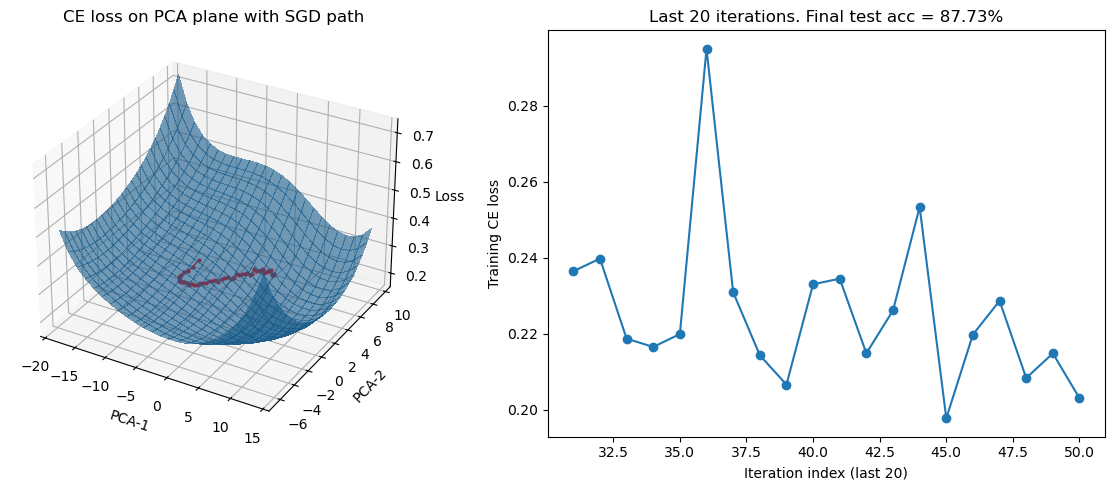

In [13]:
# Build the trajectory array from what you already recorded
trajectory = np.vstack(parameter_history)

# Plot using the full-train loader for training loss and the existing test loader
plotPath(full_train_loader, trajectory, best_model, criterion, test_loader)

In [14]:
def plotPath(train_loader_subset, parameter_history, model, criterion,
             grid_res=31, stride=1, pad_scale=0.25):
    
    # 1) PCA over trajectory
    traj = np.asarray(parameter_history)
    pca = PCA(n_components=2)
    XY = pca.fit_transform(traj)

    # 2) Build a grid that covers the path with padding
    x_min, x_max = XY[:,0].min(), XY[:,0].max()
    y_min, y_max = XY[:,1].min(), XY[:,1].max()
    dx, dy = (x_max-x_min), (y_max-y_min)
    x_min -= pad_scale*max(dx, 1e-6); x_max += pad_scale*max(dx, 1e-6)
    y_min -= pad_scale*max(dy, 1e-6); y_max += pad_scale*max(dy, 1e-6)

    xs = np.linspace(x_min, x_max, grid_res)
    ys = np.linspace(y_min, y_max, grid_res)
    Xg, Yg = np.meshgrid(xs, ys)
    Zg = np.zeros_like(Xg, dtype=np.float64)

    # 3) For each grid point, inverse-transform to weights and compute CE loss on training subset
    with torch.no_grad():
        for i in tqdm.tqdm(range(grid_res), desc="Surface rows"):
            for j in range(grid_res):
                w2 = np.array([Xg[i, j], Yg[i, j]])
                w_flat = pca.inverse_transform(w2)                # back to param space
                load_params_into_model(model, torch.from_numpy(w_flat).float())
                # unregularized CE on training subset
                Zg[i, j] = compute_loss(model, train_loader_subset, criterion)

    # restore final weights
    load_params_into_model(model, torch.from_numpy(traj[-1]).float())

    # 4) Plot surface + SGD path in that plane
    fig = plt.figure(figsize=(7,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(Xg, Yg, Zg, rstride=1, cstride=1, alpha=0.6, linewidth=0)

    # sample a few points per epoch for a cleaner path
    XY_path = XY[::max(1, stride)]
    # pick surface z by nearest grid cell
    def z_on_grid(x, y):
        ix = np.clip(np.searchsorted(xs, x)-1, 0, grid_res-1)
        iy = np.clip(np.searchsorted(ys, y)-1, 0, grid_res-1)
        return Zg[iy, ix]  # note: meshgrid indexing (row=y, col=x)
    Z_path = [z_on_grid(x, y) for x, y in XY_path]

    ax.plot(XY_path[:,0], XY_path[:,1], Z_path, color='r', marker='o', markersize=2, linewidth=1)
    ax.set_xlabel("PCA-1")
    ax.set_ylabel("PCA-2")
    ax.set_zlabel("f_CE (train)")
    ax.set_title("Cross-entropy landscape on PCA plane with SGD trajectory")
    plt.tight_layout()
    plt.show()

Surface rows: 100%|█████████████████████████████| 31/31 [00:18<00:00,  1.71it/s]


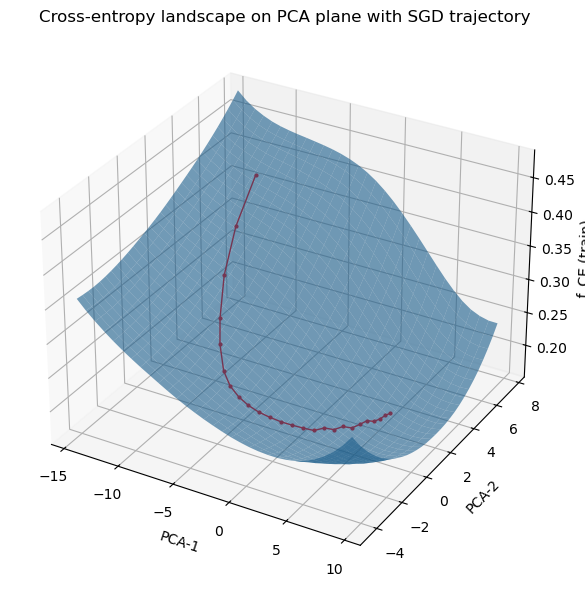

In [15]:
# Build a training subset loader for the surface (≈2500 examples)
subset_size = 2500
subset_indices = torch.randperm(len(full_train))[:subset_size]
subset = torch.utils.data.Subset(full_train, subset_indices.tolist())
surface_loader = DataLoader(subset, batch_size=256, shuffle=False)

# parameter_history already filled during final training loop
plotPath(surface_loader, np.vstack(parameter_history), best_model, criterion,
         grid_res=31, stride=2, pad_scale=0.25)

In [16]:
# 1. Data Preparation
tfm = transforms.ToTensor()  # puts pixels in [0,1]
train_set = datasets.FashionMNIST(root="./data", train=True,  download=True, transform=tfm)
test_set  = datasets.FashionMNIST(root="./data", train=False, download=True, transform=tfm)

train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
test_loader  = DataLoader(test_set,  batch_size=256, shuffle=False)

In [17]:
# 2. Autoencoder Architecture
class DenseAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),                # 28x28 -> 784
            nn.Linear(784, 128), nn.ReLU(),
            nn.Linear(128, 64),  nn.ReLU()   # latent 64
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 128), nn.ReLU(),
            nn.Linear(128, 784), nn.Sigmoid()  # back to [0,1]
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

ae = DenseAE()
criterion = nn.MSELoss()
opt = torch.optim.Adam(ae.parameters(), lr=1e-3)

In [18]:
# 3. Model Training
for epoch in range(20):
    ae.train()
    running = 0.0
    for imgs, _ in train_loader:
        x = imgs.view(imgs.size(0), -1)
        opt.zero_grad()
        x_hat = ae(imgs)
        loss = criterion(x_hat, x)
        loss.backward()
        opt.step()
        running += loss.item() * imgs.size(0)
    print(f"Epoch {epoch+1:02d}: train_mse={(running/len(train_set)):.6f}")

Epoch 01: train_mse=0.050792
Epoch 02: train_mse=0.023402
Epoch 03: train_mse=0.020306
Epoch 04: train_mse=0.018429
Epoch 05: train_mse=0.017088
Epoch 06: train_mse=0.016032
Epoch 07: train_mse=0.015269
Epoch 08: train_mse=0.014633
Epoch 09: train_mse=0.014135
Epoch 10: train_mse=0.013769
Epoch 11: train_mse=0.013338
Epoch 12: train_mse=0.013015
Epoch 13: train_mse=0.012724
Epoch 14: train_mse=0.012416
Epoch 15: train_mse=0.012174
Epoch 16: train_mse=0.011950
Epoch 17: train_mse=0.011767
Epoch 18: train_mse=0.011546
Epoch 19: train_mse=0.011397
Epoch 20: train_mse=0.011266


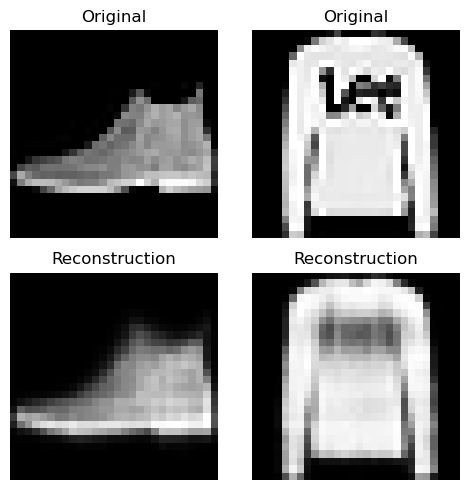

In [19]:
# 4. Visualizing Reconstructions
ae.eval()
with torch.no_grad():
    imgs, _ = next(iter(test_loader))
    x_hat = ae(imgs).view(-1, 1, 28, 28)

# pick two examples
idx = [0, 1]
orig = imgs[idx]
reco = x_hat[idx]

fig, axes = plt.subplots(2, 2, figsize=(5,5))
for i in range(2):
    axes[0, i].imshow(orig[i,0].cpu(), cmap="gray")
    axes[0, i].set_title("Original")
    axes[0, i].axis("off")
    axes[1, i].imshow(reco[i,0].cpu(), cmap="gray")
    axes[1, i].set_title("Reconstruction")
    axes[1, i].axis("off")
plt.tight_layout()
plt.show()